# Enable Agent Tutorial Part 1: YOLOv8 객체 탐지 모델 학습

## 개요

플라스틱 재활용 분류를 위한 YOLOv8 객체 탐지 모델을 학습한다.

## 데이터셋

| 클래스 | 설명 | 재활용 코드 |
|--------|------|------------|
| PET | 폴리에틸렌 테레프탈레이트 | #1 |
| PS | 폴리스타이렌 | #6 |
| PP | 폴리프로필렌 | #5 |
| PE | 폴리에틸렌 | #2, #4 |

## 데이터 구조

```
raw_data/
├── annotations/    # COCO JSON 파일들
└── images/         # 이미지 파일들
```

---
## 1. 라이브러리 설치 및 임포트

In [ ]:
# YOLOv8 설치
%pip install ultralytics -q

In [1]:
import os
import json
import shutil
import random
from pathlib import Path
from datetime import datetime
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import yaml

from ultralytics import YOLO

print(f"✓ Ultralytics YOLO 로드 완료")

✓ Ultralytics YOLO 로드 완료


---
## 2. 데이터셋 구조 확인

In [2]:
# 데이터 경로 설정
RAW_DATA_DIR = Path('raw_data')
ANNOTATIONS_DIR = RAW_DATA_DIR / 'annotations'
IMAGES_DIR = RAW_DATA_DIR / 'images'

# 데이터 존재 확인
print("=== 데이터 디렉토리 확인 ===")
print(f"raw_data 존재: {RAW_DATA_DIR.exists()}")
print(f"annotations 존재: {ANNOTATIONS_DIR.exists()}")
print(f"images 존재: {IMAGES_DIR.exists()}")
print()

if ANNOTATIONS_DIR.exists():
    json_files = list(ANNOTATIONS_DIR.glob('*.json'))
    print(f"JSON 파일 수: {len(json_files)}")
    if json_files:
        print(f"예시: {json_files[0].name}")
print()

if IMAGES_DIR.exists():
    image_files = list(IMAGES_DIR.glob('*.jpg')) + list(IMAGES_DIR.glob('*.png'))
    print(f"이미지 파일 수: {len(image_files)}")
    if image_files:
        print(f"예시: {image_files[0].name}")

=== 데이터 디렉토리 확인 ===
raw_data 존재: True
annotations 존재: True
images 존재: True

JSON 파일 수: 25
예시: plastic_test_021.json

이미지 파일 수: 25
예시: plastic_test_025.jpg


---
## 3. COCO 어노테이션 통합 로드

In [3]:
def load_all_coco_annotations(annotations_dir):
    """
    모든 COCO JSON 파일을 로드하고 통합한다.
    
    Returns:
        dict: 통합된 COCO 데이터 (images, annotations, categories)
    """
    all_images = []
    all_annotations = []
    categories = None
    
    image_id_offset = 0
    annotation_id_offset = 0
    
    json_files = list(Path(annotations_dir).glob('*.json'))
    print(f"총 {len(json_files)}개의 JSON 파일 로드 중...")
    
    for json_file in json_files:
        with open(json_file, 'r', encoding='utf-8') as f:
            coco_data = json.load(f)
        
        # 카테고리는 첫 번째 파일에서만 가져옴
        if categories is None:
            categories = coco_data.get('categories', [])
        
        # 이미지 ID 재매핑
        image_id_map = {}
        for img in coco_data.get('images', []):
            old_id = img['id']
            new_id = image_id_offset
            image_id_map[old_id] = new_id
            
            img['id'] = new_id
            all_images.append(img)
            image_id_offset += 1
        
        # 어노테이션 ID 및 image_id 재매핑
        for ann in coco_data.get('annotations', []):
            ann['id'] = annotation_id_offset
            ann['image_id'] = image_id_map[ann['image_id']]
            all_annotations.append(ann)
            annotation_id_offset += 1
    
    merged_coco = {
        'images': all_images,
        'annotations': all_annotations,
        'categories': categories
    }
    
    print(f"✓ 통합 완료:")
    print(f"  이미지: {len(all_images)}개")
    print(f"  어노테이션: {len(all_annotations)}개")
    print(f"  카테고리: {len(categories)}개")
    
    return merged_coco

# 모든 어노테이션 로드
coco_data = load_all_coco_annotations(ANNOTATIONS_DIR)

# 클래스 정보 추출
CLASSES = [cat['name'].lower() for cat in coco_data['categories']]
print(f"\n클래스: {CLASSES}")

총 25개의 JSON 파일 로드 중...
✓ 통합 완료:
  이미지: 25개
  어노테이션: 125개
  카테고리: 4개

클래스: ['pet', 'ps', 'pp', 'pe']


---
## 4. COCO to YOLO 포맷 변환

### YOLO 포맷

```
<class_id> <x_center> <y_center> <width> <height>
```

- 모든 값은 0~1 사이로 정규화
- 좌표는 이미지 크기 기준 상대값

In [4]:
def coco_to_yolo_bbox(bbox, img_width, img_height):
    """
    COCO bbox를 YOLO 포맷으로 변환한다.
    
    Args:
        bbox: [x, y, width, height] (COCO 포맷)
        img_width: 이미지 너비
        img_height: 이미지 높이
    
    Returns:
        list: [x_center, y_center, width, height] (YOLO 포맷, 정규화됨)
    """
    x, y, w, h = bbox
    
    # YOLO 포맷: x_center, y_center, width, height (정규화)
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    w_norm = w / img_width
    h_norm = h / img_height
    
    return [x_center, y_center, w_norm, h_norm]

print("✓ COCO to YOLO 변환 함수 정의 완료")

✓ COCO to YOLO 변환 함수 정의 완료


---
## 5. Train/Val Split (8:2)

In [5]:
# 이미지 ID 리스트
all_image_ids = [img['id'] for img in coco_data['images']]

# 랜덤 셔플
random.seed(42)
random.shuffle(all_image_ids)

# 8:2 분할
split_idx = int(len(all_image_ids) * 0.8)
train_image_ids = set(all_image_ids[:split_idx])
val_image_ids = set(all_image_ids[split_idx:])

print("=== Train/Val Split ===")
print(f"Train 이미지: {len(train_image_ids)}개")
print(f"Val 이미지: {len(val_image_ids)}개")
print(f"비율: {len(train_image_ids)/len(all_image_ids):.1%} / {len(val_image_ids)/len(all_image_ids):.1%}")

=== Train/Val Split ===
Train 이미지: 20개
Val 이미지: 5개
비율: 80.0% / 20.0%


---
## 6. YOLO 데이터셋 생성

In [6]:
def create_yolo_dataset(coco_data, train_ids, val_ids, output_base_dir, images_source_dir):
    """
    COCO 데이터를 YOLO 포맷으로 변환하고 train/val로 분할한다.
    
    Args:
        coco_data: COCO 어노테이션 데이터
        train_ids: 학습 이미지 ID 집합
        val_ids: 검증 이미지 ID 집합
        output_base_dir: 출력 베이스 디렉토리
        images_source_dir: 원본 이미지 디렉토리
    """
    output_base_dir = Path(output_base_dir)
    images_source_dir = Path(images_source_dir)
    
    # 디렉토리 생성
    for split in ['train', 'val']:
        (output_base_dir / split / 'images').mkdir(parents=True, exist_ok=True)
        (output_base_dir / split / 'labels').mkdir(parents=True, exist_ok=True)
    
    # 이미지 ID -> 이미지 정보 매핑
    images_info = {img['id']: img for img in coco_data['images']}
    
    # 이미지별 어노테이션 그룹화
    image_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        image_annotations[ann['image_id']].append(ann)
    
    # 카테고리 ID -> 인덱스 매핑
    category_id_to_idx = {cat['id']: i for i, cat in enumerate(coco_data['categories'])}
    
    train_count = 0
    val_count = 0
    
    # 각 이미지 처리
    for img_id, img_info in images_info.items():
        # Train/Val 구분
        if img_id in train_ids:
            split = 'train'
            train_count += 1
        elif img_id in val_ids:
            split = 'val'
            val_count += 1
        else:
            continue
        
        img_filename = img_info['file_name']
        img_width = img_info['width']
        img_height = img_info['height']
        
        # 이미지 파일 복사
        src_img_path = images_source_dir / img_filename
        dst_img_path = output_base_dir / split / 'images' / img_filename
        
        if src_img_path.exists():
            shutil.copy(src_img_path, dst_img_path)
        else:
            print(f"⚠️  이미지를 찾을 수 없음: {src_img_path}")
            continue
        
        # YOLO 라벨 생성
        label_filename = Path(img_filename).stem + '.txt'
        label_path = output_base_dir / split / 'labels' / label_filename
        
        yolo_annotations = []
        
        for ann in image_annotations[img_id]:
            # COCO bbox: [x, y, width, height]
            bbox = ann['bbox']
            category_id = ann['category_id']
            
            # 클래스 인덱스
            class_idx = category_id_to_idx[category_id]
            
            # YOLO bbox로 변환
            yolo_bbox = coco_to_yolo_bbox(bbox, img_width, img_height)
            
            # YOLO 라벨 형식: class x_center y_center width height
            yolo_line = f"{class_idx} {' '.join(map(str, yolo_bbox))}"
            yolo_annotations.append(yolo_line)
        
        # 라벨 파일 저장
        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))
    
    print("\n=== 데이터셋 생성 완료 ===")
    print(f"Train: {train_count}개 (이미지 + 라벨)")
    print(f"Val: {val_count}개 (이미지 + 라벨)")
    
    return train_count, val_count

# YOLO 데이터셋 생성
OUTPUT_DIR = Path('datasets/plastic')
train_cnt, val_cnt = create_yolo_dataset(
    coco_data,
    train_image_ids,
    val_image_ids,
    OUTPUT_DIR,
    IMAGES_DIR
)


=== 데이터셋 생성 완료 ===
Train: 20개 (이미지 + 라벨)
Val: 5개 (이미지 + 라벨)


---
## 7. YAML 설정 파일 생성

In [7]:
# YAML 설정 생성
yaml_config = {
    'path': str(OUTPUT_DIR.absolute()),
    'train': 'train/images',
    'val': 'val/images',
    'nc': len(CLASSES),
    'names': CLASSES
}

yaml_path = Path('datasets/plastic.yaml')
yaml_path.parent.mkdir(exist_ok=True)

with open(yaml_path, 'w') as f:
    yaml.dump(yaml_config, f, default_flow_style=False)

print("=== YAML 설정 파일 ===")
print(yaml_path)
print()
with open(yaml_path, 'r') as f:
    print(f.read())

=== YAML 설정 파일 ===
datasets/plastic.yaml

names:
- pet
- ps
- pp
- pe
nc: 4
path: /Users/namuai/03-books/enable-agent/04-yolo_enable_agent_tutorial/datasets/plastic
train: train/images
val: val/images



---
## 8. 데이터 시각화

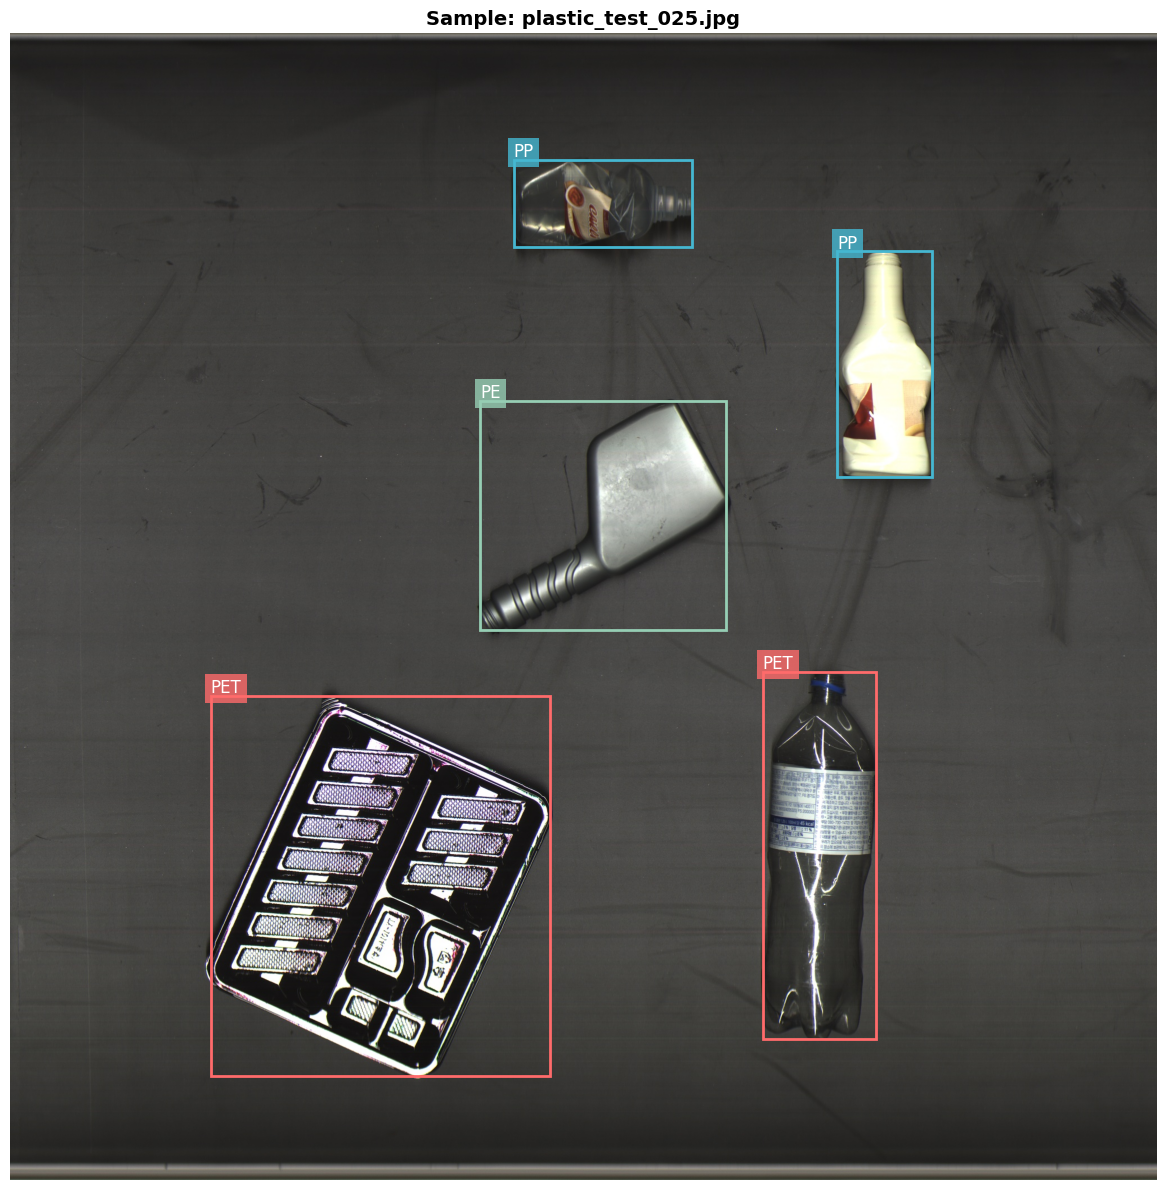

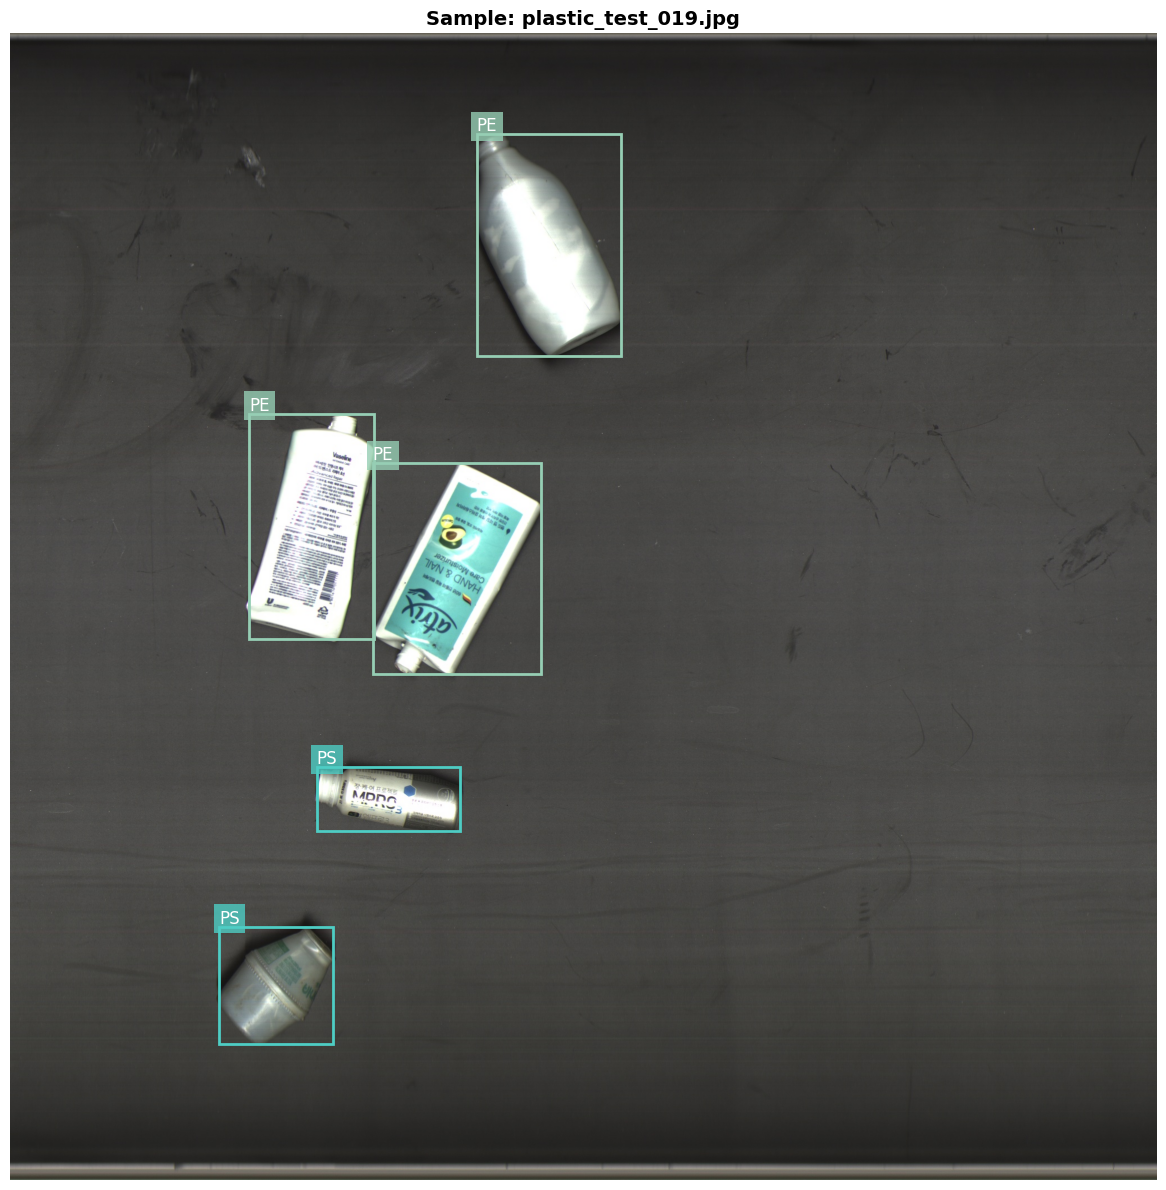

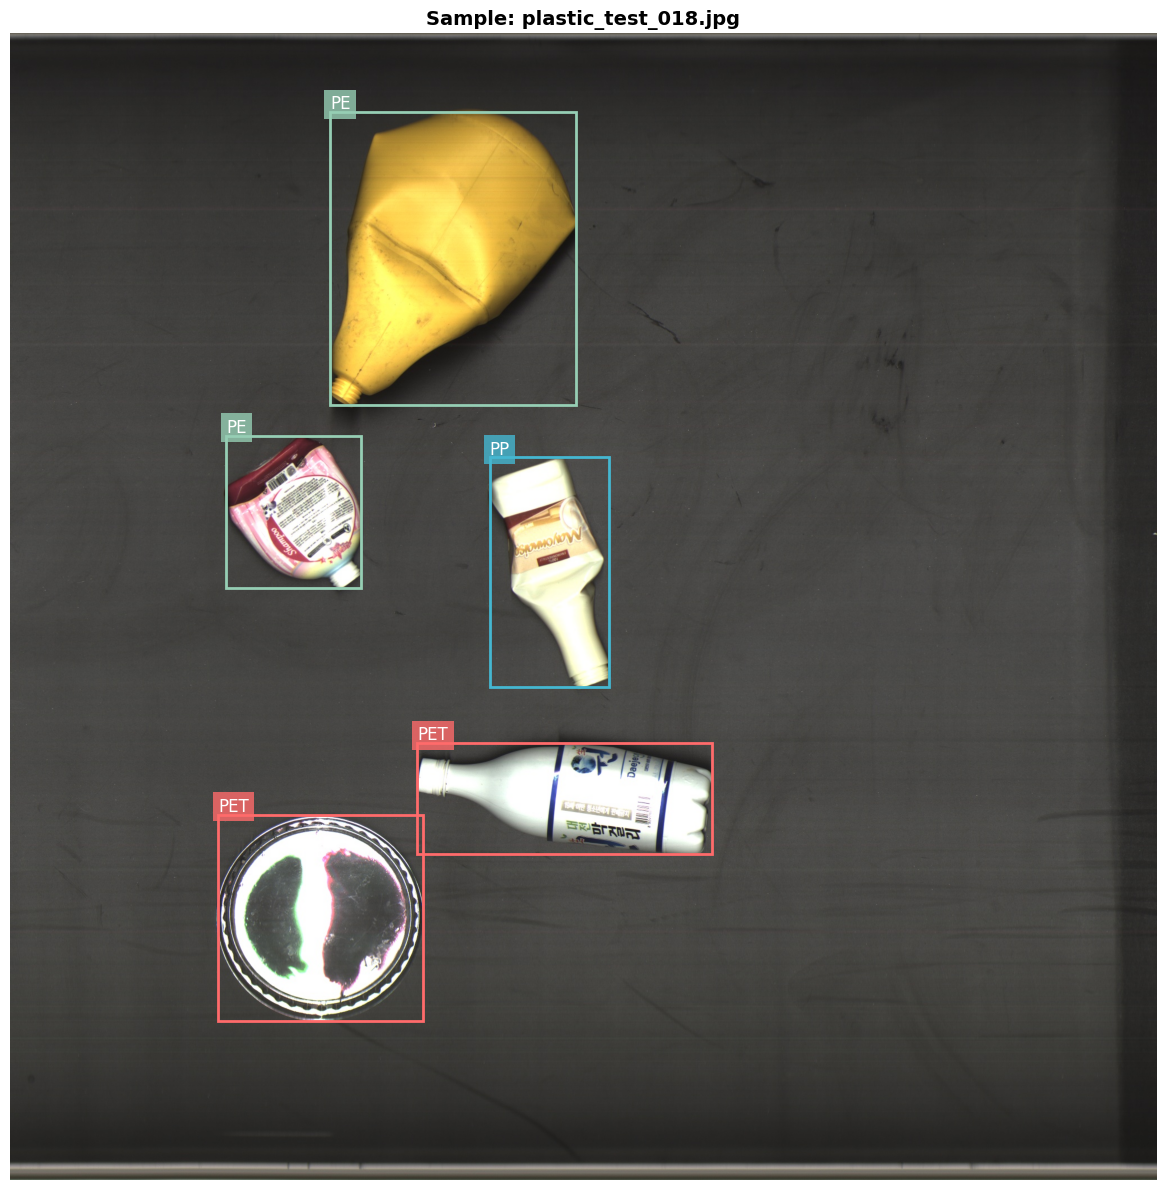

In [8]:
# 샘플 이미지 시각화
def visualize_yolo_sample(image_path, label_path, class_names):
    """
    YOLO 포맷 데이터를 시각화한다.
    """
    # 이미지 로드
    img = Image.open(image_path)
    img_width, img_height = img.size
    
    # 라벨 로드
    with open(label_path, 'r') as f:
        labels = f.readlines()
    
    # 시각화
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img)
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    for label in labels:
        parts = label.strip().split()
        if len(parts) < 5:
            continue
        
        class_idx = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:5])
        
        # YOLO -> 픽셀 좌표 변환
        x_center_px = x_center * img_width
        y_center_px = y_center * img_height
        width_px = width * img_width
        height_px = height * img_height
        
        # 좌상단 좌표
        x1 = x_center_px - width_px / 2
        y1 = y_center_px - height_px / 2
        
        # 바운딩 박스 그리기
        rect = patches.Rectangle(
            (x1, y1), width_px, height_px,
            linewidth=2,
            edgecolor=colors[class_idx],
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # 클래스 레이블
        ax.text(
            x1, y1 - 5,
            class_names[class_idx].upper(),
            color='white',
            fontsize=12,
            bbox=dict(facecolor=colors[class_idx], alpha=0.8, edgecolor='none')
        )
    
    ax.axis('off')
    plt.title(f'Sample: {image_path.name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Train 샘플 시각화
train_images = list((OUTPUT_DIR / 'train' / 'images').glob('*.jpg'))[:3]

for img_path in train_images:
    label_path = OUTPUT_DIR / 'train' / 'labels' / (img_path.stem + '.txt')
    if label_path.exists():
        visualize_yolo_sample(img_path, label_path, CLASSES)

---
## 9. YOLOv8 모델 초기화

In [9]:
# YOLOv8 모델 로드
model = YOLO('yolov8n.pt')  # Nano 모델 (가볍고 빠름)

print("=== 모델 정보 ===")
print(f"모델: YOLOv8n")
print(f"클래스 수: {len(CLASSES)}")
print(f"클래스: {CLASSES}")

=== 모델 정보 ===
모델: YOLOv8n
클래스 수: 4
클래스: ['pet', 'ps', 'pp', 'pe']


---
## 10. 모델 학습

In [10]:
# 모델 학습
results = model.train(
    data='datasets/plastic.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    patience=10,
    save=True,
    name='plastic_yolov8',
    exist_ok=True,
    pretrained=True,
    optimizer='auto',
    verbose=True,
    seed=42,
    deterministic=True,
    cos_lr=True,
    resume=False,
    amp=True,
    lr0=0.01,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3,
    plots=True
)

New https://pypi.org/project/ultralytics/8.4.2 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.250 🚀 Python-3.11.13 torch-2.8.0 CPU (Apple M4)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=datasets/plastic.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=plastic_yolov8, nbs=64, nms=False, opset=None, optimize=False, opti

In [11]:
# 학습 결과 확인
print("=== 학습 결과 ===")
print(f"Best 모델: runs/detect/plastic_yolov8/weights/best.pt")
print(f"Last 모델: runs/detect/plastic_yolov8/weights/last.pt")

=== 학습 결과 ===
Best 모델: runs/detect/plastic_yolov8/weights/best.pt
Last 모델: runs/detect/plastic_yolov8/weights/last.pt


---
## 11. 모델 평가

In [13]:
# 검증 데이터로 평가
best_model = YOLO('runs/detect/plastic_yolov8/weights/best.pt')

val_results = best_model.val(
    data='datasets/plastic.yaml',
    split='val',
    imgsz=640,
    batch=16,
    conf=0.25,
    iou=0.6,
    plots=True
)

Ultralytics 8.3.250 🚀 Python-3.11.13 torch-2.8.0 CPU (Apple M4)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 1274.0±423.8 MB/s, size: 649.2 KB)
val: Scanning /Users/namuai/03-books/enable-agent/04-yolo_enable_agent_tutorial/datasets/plastic/val/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 6/6 18.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 3.1it/s 0.3s
                   all          6         30      0.871      0.751       0.86      0.852
                   pet          5          9      0.818          1      0.995      0.979
                    ps          2          3      0.667      0.667      0.777      0.777
                    pp          5         11          1      0.909      0.955      0.937
                    pe          5          7          1      0.429      0.714      0.714
Speed: 1.0m

In [14]:
# 평가 지표 출력
print("=== 검증 결과 ===")
print(f"mAP50: {val_results.box.map50:.4f}")
print(f"mAP50-95: {val_results.box.map:.4f}")
print(f"Precision: {val_results.box.mp:.4f}")
print(f"Recall: {val_results.box.mr:.4f}")

print("\n=== 클래스별 AP ===")
for i, cls_name in enumerate(CLASSES):
    if i < len(val_results.box.ap50):
        print(f"  {cls_name.upper()}: {val_results.box.ap50[i]:.4f}")

=== 검증 결과 ===
mAP50: 0.8602
mAP50-95: 0.8520
Precision: 0.8712
Recall: 0.7511

=== 클래스별 AP ===
  PET: 0.9950
  PS: 0.7772
  PP: 0.9545
  PE: 0.7143


---
## 12. 추론 테스트

In [15]:
# 샘플 이미지 추론
test_images = list(Path('datasets/plastic/val/images').glob('*.jpg'))

if test_images:
    test_img = test_images[0]
    
    results = best_model.predict(
        source=str(test_img),
        conf=0.25,
        iou=0.45,
        save=True,
        project='runs/detect',
        name='test_predictions'
    )
    
    # 결과 출력
    for result in results:
        print(f"\n이미지: {result.path}")
        print(f"탐지된 객체: {len(result.boxes)}")
        
        for box in result.boxes:
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            cls_name = CLASSES[cls_id]
            print(f"  - {cls_name.upper()}: {conf:.2%}")


image 1/1 /Users/namuai/03-books/enable-agent/04-yolo_enable_agent_tutorial/datasets/plastic/val/images/plastic_test_021.jpg: 640x640 1 pet, 2 pss, 49.8ms
Speed: 2.6ms preprocess, 49.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /Users/namuai/03-books/enable-agent/04-yolo_enable_agent_tutorial/runs/detect/runs/detect/test_predictions

이미지: /Users/namuai/03-books/enable-agent/04-yolo_enable_agent_tutorial/datasets/plastic/val/images/plastic_test_021.jpg
탐지된 객체: 3
  - PET: 82.49%
  - PS: 75.78%
  - PS: 31.90%


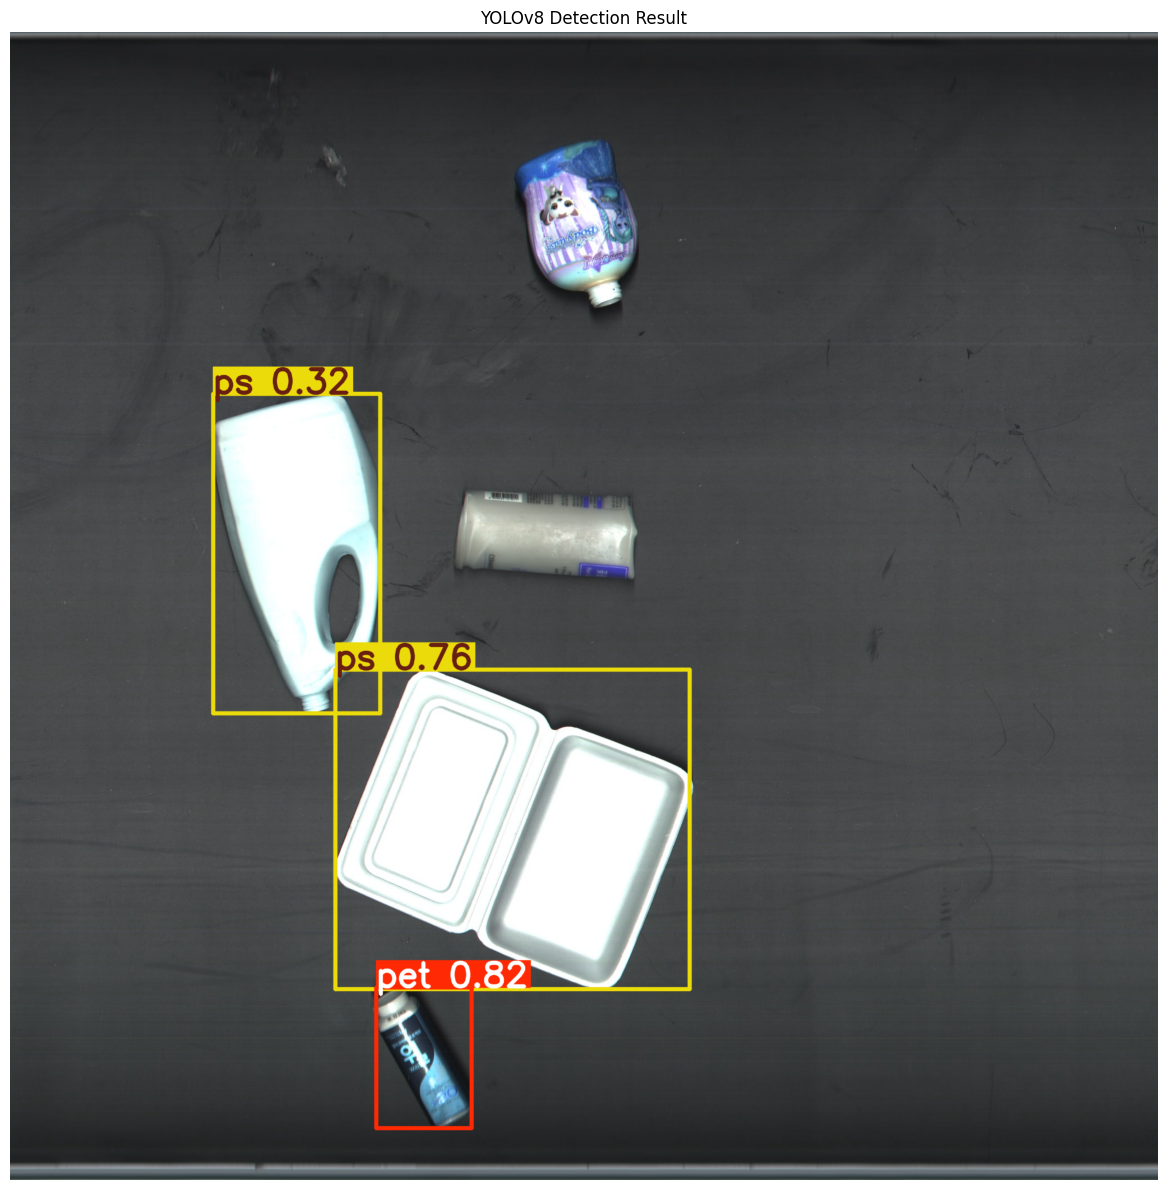

In [16]:
# 추론 결과 시각화
if test_images:
    result = results[0]
    
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(result.plot())
    ax.axis('off')
    plt.title('YOLOv8 Detection Result')
    plt.tight_layout()
    plt.show()

---
## 13. 모델 저장 및 내보내기

In [17]:
# 모델 파일 정리
Path('models').mkdir(exist_ok=True)

# best 모델 복사
src_model = Path('runs/detect/plastic_yolov8/weights/best.pt')
if src_model.exists():
    dst_model = Path('models/plastic_yolov8_best.pt')
    shutil.copy(src_model, dst_model)
    print(f"✓ 모델 저장: {dst_model}")

# 메타데이터 저장
metadata = {
    'model_name': 'plastic_yolov8',
    'base_model': 'yolov8n',
    'classes': CLASSES,
    'num_classes': len(CLASSES),
    'input_size': 640,
    'trained_at': datetime.now().isoformat(),
    'dataset': {
        'train_images': train_cnt,
        'val_images': val_cnt,
        'total_images': train_cnt + val_cnt
    },
    'metrics': {
        'mAP50': float(val_results.box.map50) if 'val_results' in dir() else None,
        'mAP50-95': float(val_results.box.map) if 'val_results' in dir() else None,
        'precision': float(val_results.box.mp) if 'val_results' in dir() else None,
        'recall': float(val_results.box.mr) if 'val_results' in dir() else None
    }
}

with open('models/yolo_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"✓ 메타데이터 저장: models/yolo_metadata.json")
print()
print("메타데이터 내용:")
print(json.dumps(metadata, indent=2, ensure_ascii=False))

✓ 모델 저장: models/plastic_yolov8_best.pt
✓ 메타데이터 저장: models/yolo_metadata.json

메타데이터 내용:
{
  "model_name": "plastic_yolov8",
  "base_model": "yolov8n",
  "classes": [
    "pet",
    "ps",
    "pp",
    "pe"
  ],
  "num_classes": 4,
  "input_size": 640,
  "trained_at": "2026-01-15T13:04:33.692076",
  "dataset": {
    "train_images": 20,
    "val_images": 5,
    "total_images": 25
  },
  "metrics": {
    "mAP50": 0.8602437500000001,
    "mAP50-95": 0.851952,
    "precision": 0.8712121212121212,
    "recall": 0.751082251082251
  }
}
